In [1]:
import os

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

if os.getcwd().endswith('notebook'):
    os.chdir('..')

from rna_learn.model import (
    rnn_classification_model,
    compile_classification_model,
)
from rna_learn.transform import (
    sequence_embedding, 
    make_dataset_balanced,
    one_hot_encode_classes,
    split_train_test_set,
    normalize, 
    denormalize,
)
from rna_learn.load import load_rna_nucleotides_dataset
from rna_learn.vae import variational_autoencoder, compile_vae

In [2]:
seed = 567
np.random.seed(seed)

sns.set(palette='colorblind', font_scale=1.3)

## Model

In [3]:
rna = 'mrna'
alphabet = ['A', 'T', 'G', 'C']
alphabet_size = len(alphabet)
metadata_folder = f'data/rna_temp/tab/{rna}.tab'
sequences_folder = 'data/rna_temp/seq/'
classes = ['psychrophile', 'mesophile', 'thermophile', 'hyperthermophile']
n_classes = len(classes)
n_entries_per_class = 153

In [4]:
output_path = os.path.join(os.getcwd(), 'saved_models', f'seed_{seed}', f'{rna}_classification.h5')

model = rnn_classification_model(alphabet_size=alphabet_size, n_classes=n_classes, n_lstm=2)
compile_classification_model(model, learning_rate=1e-4)

model.load_weights(output_path)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        [(None, None, 4)]         0         
_________________________________________________________________
masking (Masking)            (None, None, 4)           0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 100)         42000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 404   

## Data

In [5]:
%%time
metadata = pd.read_csv(metadata_folder, delimiter='\t')
metadata['category'] = metadata['temp.cat']

sequences = load_rna_nucleotides_dataset(metadata, sequences_folder)

CPU times: user 339 ms, sys: 267 ms, total: 607 ms
Wall time: 608 ms


In [6]:
y_balanced, balanced_metadata = make_dataset_balanced(metadata, n_entries_per_class=n_entries_per_class)

In [7]:
balanced_sequences = load_rna_nucleotides_dataset(balanced_metadata, sequences_folder)
y = one_hot_encode_classes(y_balanced, classes)
x = sequence_embedding(balanced_sequences, alphabet)
x_train, y_train, x_test, y_test, train_idx, test_idx = split_train_test_set(
    x, y, test_ratio=0.2, return_indices=True)

## Evaluation

In [8]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')

Loss: 1.3528
Accuracy: 0.3770


## Confusion matrix (test set)

In [9]:
y_pred = model(x_test)

labels = [np.argmax(el) for el in y_test]
predictions = [np.argmax(el) for el in y_pred]
conf = tf.math.confusion_matrix(labels, predictions).numpy()
conf

array([[24,  5,  1,  0],
       [17,  6,  4,  7],
       [12,  8, 11,  3],
       [11,  6,  2,  5]], dtype=int32)

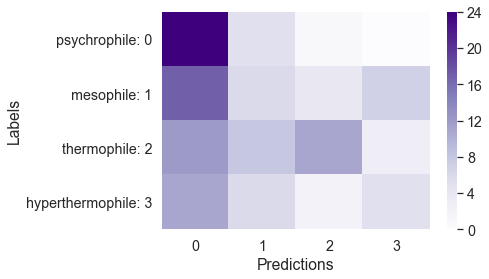

In [10]:
df_cm = pd.DataFrame(
    conf, 
    index=[f'{c}: {i}' for i, c in enumerate(classes)],
    columns=[f'{i}' for i, c in enumerate(classes)],
)
ax = sns.heatmap(df_cm, cmap="Purples");
ax.set_xlabel('Predictions');
ax.set_ylabel('Labels');

In [11]:
conf_sum = np.sum(conf, axis=1)
for i in range(len(classes)):
    acc = 100 * conf[i, i] / conf_sum[i]
    print(f'Accuracy for class {classes[i]}: {acc:.1f}%')

Accuracy for class psychrophile: 80.0%
Accuracy for class mesophile: 17.6%
Accuracy for class thermophile: 32.4%
Accuracy for class hyperthermophile: 20.8%


## Confusion matrix (train set)

In [12]:
y_pred_t = model(x_train)

labels_t = [np.argmax(el) for el in y_train]
predictions_t = [np.argmax(el) for el in y_pred_t]
conf_t = tf.math.confusion_matrix(labels_t, predictions_t).numpy()
conf_t

array([[99,  7,  8,  9],
       [49, 43, 15, 12],
       [48, 28, 26, 17],
       [69, 18,  4, 38]], dtype=int32)

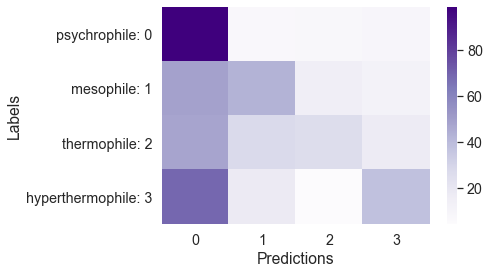

In [13]:
df_cm_t = pd.DataFrame(
    conf_t, 
    index=[f'{c}: {i}' for i, c in enumerate(classes)],
    columns=[f'{i}' for i, c in enumerate(classes)],
)
ax = sns.heatmap(df_cm_t, cmap="Purples");
ax.set_xlabel('Predictions');
ax.set_ylabel('Labels');

In [14]:
conf_sum_t = np.sum(conf_t, axis=1)
for i in range(len(classes)):
    acc = 100 * conf_t[i, i] / conf_sum_t[i]
    print(f'Accuracy for class {classes[i]}: {acc:.1f}%')

Accuracy for class psychrophile: 80.5%
Accuracy for class mesophile: 36.1%
Accuracy for class thermophile: 21.8%
Accuracy for class hyperthermophile: 29.5%


## VAE

In [15]:
prior, encoder, decoder, vae = variational_autoencoder(n_inputs=100, encoding_size=2, n_hidden=300)
compile_vae(vae, learning_rate=1e-4)
vae.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               30300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1505      
_________________________________________________________________
multivariate_normal_tri_l (M ((None, 2), (None, 2))    0         
_________________________________________________________________
model_2 (Model)              (None, 100)               61100     
Total params: 92,905
Trainable params: 92,905
Non-trainable params: 0
_______________________________________________________

In [16]:
layer_name = 'dense'
intermediate_layer_model = tf.keras.Model(
    inputs=model.input,
    outputs=model.get_layer(layer_name).output,
)
train_logits = intermediate_layer_model(x_train).numpy()
test_logits = intermediate_layer_model(x_test).numpy()
print(train_logits.shape, test_logits.shape)

(490, 100) (122, 100)


In [17]:
do_train_vae = True
vae_model_path = os.path.join(os.getcwd(), 'saved_models', f'seed_{seed}', f'{rna}_vae.h5')

if do_train_vae:
    vae.fit(
        train_logits, train_logits,
        validation_data=(test_logits, test_logits),
        batch_size=32,
        epochs=500,
    )
    vae.save(vae_model_path)
else:
    vae.load_weights(vae_model_path)

Train on 490 samples, validate on 122 samples
Epoch 1/500
490/490 [==============================] - 2s 4ms/sample - loss: 56.5374 - val_loss: 55.3433
Epoch 2/500
490/490 [==============================] - 0s 135us/sample - loss: 55.1851 - val_loss: 53.8251
Epoch 3/500
490/490 [==============================] - 0s 122us/sample - loss: 53.7781 - val_loss: 52.3100
Epoch 4/500
490/490 [==============================] - 0s 138us/sample - loss: 51.7295 - val_loss: 50.5535
Epoch 5/500
490/490 [==============================] - 0s 157us/sample - loss: 50.3130 - val_loss: 47.6460
Epoch 6/500
490/490 [==============================] - 0s 178us/sample - loss: 47.9642 - val_loss: 46.0107
Epoch 7/500
490/490 [==============================] - 0s 125us/sample - loss: 45.5082 - val_loss: 42.4410
Epoch 8/500
490/490 [==============================] - 0s 118us/sample - loss: 41.9378 - val_loss: 38.5657
Epoch 9/500
490/490 [==============================] - 0s 124us/sample - loss: 39.0826 - val_loss: 3

Epoch 76/500
490/490 [==============================] - 0s 108us/sample - loss: -70.5700 - val_loss: -97.2772
Epoch 77/500
490/490 [==============================] - 0s 103us/sample - loss: -71.9820 - val_loss: -97.9805
Epoch 78/500
490/490 [==============================] - 0s 102us/sample - loss: -72.7035 - val_loss: -99.3348
Epoch 79/500
490/490 [==============================] - 0s 105us/sample - loss: -72.6694 - val_loss: -99.8142
Epoch 80/500
490/490 [==============================] - 0s 112us/sample - loss: -74.4240 - val_loss: -100.3665
Epoch 81/500
490/490 [==============================] - 0s 106us/sample - loss: -74.8206 - val_loss: -101.3240
Epoch 82/500
490/490 [==============================] - 0s 104us/sample - loss: -75.0932 - val_loss: -102.7680
Epoch 83/500
490/490 [==============================] - 0s 105us/sample - loss: -75.8890 - val_loss: -102.4908
Epoch 84/500
490/490 [==============================] - 0s 104us/sample - loss: -77.2749 - val_loss: -103.5425
Epoch

490/490 [==============================] - 0s 141us/sample - loss: -135.8632 - val_loss: -163.6301
Epoch 150/500
490/490 [==============================] - 0s 113us/sample - loss: -137.1354 - val_loss: -164.2867
Epoch 151/500
490/490 [==============================] - 0s 114us/sample - loss: -138.4080 - val_loss: -166.1683
Epoch 152/500
490/490 [==============================] - 0s 108us/sample - loss: -140.0265 - val_loss: -166.7150
Epoch 153/500
490/490 [==============================] - 0s 105us/sample - loss: -140.6453 - val_loss: -168.7971
Epoch 154/500
490/490 [==============================] - 0s 103us/sample - loss: -141.2286 - val_loss: -169.3629
Epoch 155/500
490/490 [==============================] - 0s 110us/sample - loss: -143.0335 - val_loss: -169.6519
Epoch 156/500
490/490 [==============================] - 0s 109us/sample - loss: -144.0356 - val_loss: -170.5795
Epoch 157/500
490/490 [==============================] - 0s 111us/sample - loss: -146.4248 - val_loss: -171.58

490/490 [==============================] - 0s 121us/sample - loss: -224.5490 - val_loss: -246.3767
Epoch 222/500
490/490 [==============================] - 0s 112us/sample - loss: -225.6683 - val_loss: -248.3236
Epoch 223/500
490/490 [==============================] - 0s 106us/sample - loss: -227.4115 - val_loss: -249.4143
Epoch 224/500
490/490 [==============================] - 0s 104us/sample - loss: -225.3186 - val_loss: -244.7969
Epoch 225/500
490/490 [==============================] - 0s 103us/sample - loss: -226.6003 - val_loss: -246.1165
Epoch 226/500
490/490 [==============================] - 0s 110us/sample - loss: -227.1938 - val_loss: -249.3483
Epoch 227/500
490/490 [==============================] - 0s 113us/sample - loss: -228.3217 - val_loss: -251.1270
Epoch 228/500
490/490 [==============================] - 0s 114us/sample - loss: -228.6874 - val_loss: -252.7589
Epoch 229/500
490/490 [==============================] - 0s 121us/sample - loss: -229.2007 - val_loss: -251.12

490/490 [==============================] - 0s 120us/sample - loss: -267.2757 - val_loss: -287.3031
Epoch 294/500
490/490 [==============================] - 0s 107us/sample - loss: -265.3158 - val_loss: -287.6845
Epoch 295/500
490/490 [==============================] - 0s 102us/sample - loss: -220.8919 - val_loss: -270.1660
Epoch 296/500
490/490 [==============================] - 0s 105us/sample - loss: -239.4707 - val_loss: -267.7408
Epoch 297/500
490/490 [==============================] - 0s 107us/sample - loss: -254.8826 - val_loss: -270.8496
Epoch 298/500
490/490 [==============================] - 0s 106us/sample - loss: -256.9042 - val_loss: -275.7022
Epoch 299/500
490/490 [==============================] - 0s 104us/sample - loss: -262.3446 - val_loss: -279.5657
Epoch 300/500
490/490 [==============================] - 0s 106us/sample - loss: -263.6429 - val_loss: -283.0738
Epoch 301/500
490/490 [==============================] - 0s 104us/sample - loss: -264.2268 - val_loss: -284.34

490/490 [==============================] - 0s 130us/sample - loss: -281.3656 - val_loss: -301.3988
Epoch 366/500
490/490 [==============================] - 0s 119us/sample - loss: -281.5545 - val_loss: -302.2880
Epoch 367/500
490/490 [==============================] - 0s 104us/sample - loss: -269.0616 - val_loss: -295.8422
Epoch 368/500
490/490 [==============================] - 0s 108us/sample - loss: -271.2848 - val_loss: -295.1153
Epoch 369/500
490/490 [==============================] - 0s 109us/sample - loss: -275.9937 - val_loss: -297.0840
Epoch 370/500
490/490 [==============================] - 0s 108us/sample - loss: -277.1181 - val_loss: -298.9982
Epoch 371/500
490/490 [==============================] - 0s 103us/sample - loss: -281.3567 - val_loss: -299.1250
Epoch 372/500
490/490 [==============================] - 0s 105us/sample - loss: -278.2244 - val_loss: -301.5798
Epoch 373/500
490/490 [==============================] - 0s 109us/sample - loss: -280.5263 - val_loss: -301.69

490/490 [==============================] - 0s 116us/sample - loss: -288.4861 - val_loss: -309.2659
Epoch 438/500
490/490 [==============================] - 0s 108us/sample - loss: -289.7300 - val_loss: -311.2183
Epoch 439/500
490/490 [==============================] - 0s 104us/sample - loss: -289.6291 - val_loss: -311.0804
Epoch 440/500
490/490 [==============================] - 0s 102us/sample - loss: -285.3686 - val_loss: -309.1512
Epoch 441/500
490/490 [==============================] - 0s 103us/sample - loss: -281.4915 - val_loss: -304.8306
Epoch 442/500
490/490 [==============================] - 0s 102us/sample - loss: -278.5994 - val_loss: -305.6729
Epoch 443/500
490/490 [==============================] - 0s 101us/sample - loss: -279.3399 - val_loss: -304.1540
Epoch 444/500
490/490 [==============================] - 0s 101us/sample - loss: -288.6498 - val_loss: -308.0122
Epoch 445/500
490/490 [==============================] - 0s 103us/sample - loss: -289.2622 - val_loss: -310.29

In [33]:
encoding_test_dist = encoder(test_logits)
encoding_test = encoding_test_dist.mean().numpy()

encoding_train_dist = encoder(train_logits)
encoding_train = encoding_train_dist.mean().numpy()

In [19]:
def plot_encoding(encoding, labels, figsize=(12, 6), show_only=None):
    f, ax = plt.subplots(1, 1, figsize=figsize)
    
    palette = sns.color_palette()
    
    for i, code in enumerate(encoding):
        if show_only is not None and labels[i] not in show_only:
            continue
        ax.plot(code[0], code[1], 'o', color=palette[labels[i]])
    
    return f, ax

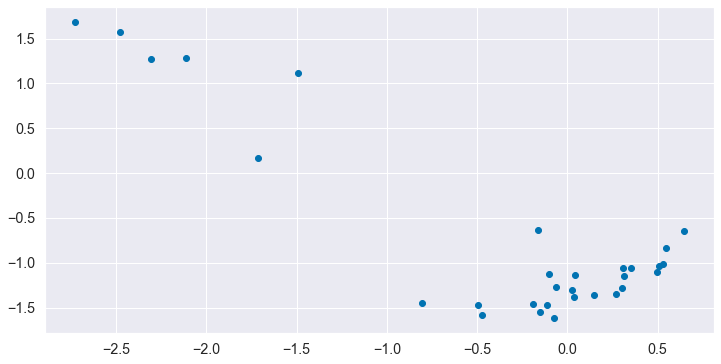

In [25]:
plot_encoding(encoding_test, labels, show_only=(0,));

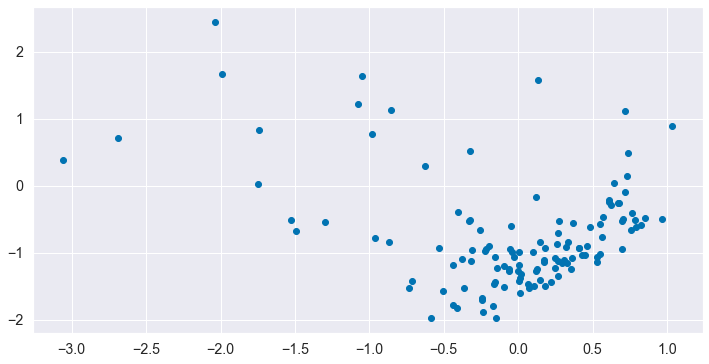

In [34]:
plot_encoding(encoding_train, labels_t, show_only=(0,));

In [26]:
def plot_encoding_with_colors(encoding, labels, color_vals, figsize=(12, 6), show_only=None):
    f, ax = plt.subplots(1, 1, figsize=figsize)
    
    palette = sns.color_palette()
    
    x_d, y_d = [], []
    colors = []
    
    for i, code in enumerate(encoding):
        if show_only is not None and labels[i] not in show_only:
            continue
        
        x_d.append(encoding[i,0])
        y_d.append(encoding[i,1])
        colors.append(color_vals[i])
    
    sc = ax.scatter(x_d, y_d, c=colors, cmap='YlOrRd')
    plt.colorbar(sc)
    
    return f, ax

In [27]:
temp_test = balanced_metadata.iloc[test_idx]['temp'].values

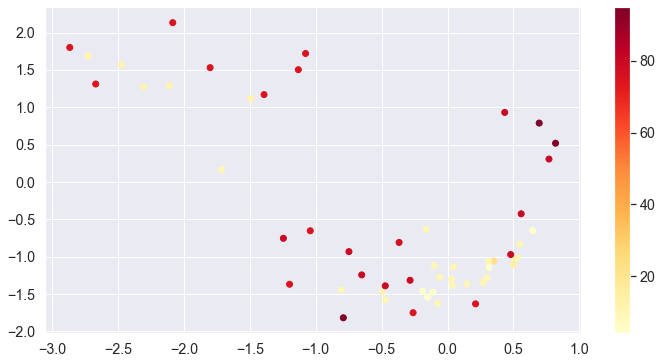

In [32]:
plot_encoding_with_colors(encoding_test, labels, temp_test, show_only=(0, 3));